# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

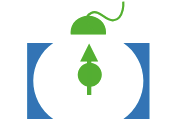

In [2]:
# initial state is a thermal state
n_average = 5
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
num_dicts = 10
initial_params = {
    "POVM": jnp.array([0.1, -3 * jnp.pi/2]),
}
import random
param_keys = list(initial_params.keys())
random_params = []
for _ in range(num_dicts):
    rand_num = random.randint(1, 50)
    d = {}
    for k in param_keys:
        v = jnp.asarray(initial_params[k])
        # Generate random parameters with the same shape as v, uniformly between -2pi and 2pi
        d[k] = jax.random.uniform(
            jax.random.PRNGKey(rand_num), shape=v.shape, minval=-2 * jnp.pi, maxval=2 * jnp.pi
        ).tolist()
    random_params.append(d)
print(random_params)

[{'POVM': [3.16588658562983, -4.8295302352785185]}, {'POVM': [5.326147862293889, 3.189315559809533]}, {'POVM': [-3.500206390330003, -0.7426815007087333]}, {'POVM': [5.351308675502783, -2.0729433777618254]}, {'POVM': [2.7626293411407135, -4.5210143150684825]}, {'POVM': [5.5018106583115856, 5.284277048180829]}, {'POVM': [-2.4658946915082685, 1.814989863698892]}, {'POVM': [3.04867711595889, -6.043126529929224]}, {'POVM': [-6.164985980362262, -0.037231205061736605]}, {'POVM': [-1.3143802767244022, 3.8162383204950854]}]


In [6]:
# TODO: Have a default NN and then give user the ability to supply a model or a function
# With log p terms: 0.0.9984141684258416
# Without log p terms: 0.999796307373522
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation
from feedback_grape.fgrape_helpers import RNN
import numpy as np
# Create an array of dicts with random initializations between -2pi and 2pi

for i in range(10):
    
    result = optimize_pulse_with_feedback(
        U_0=rho_cav,
        C_target=None,
        parameterized_gates=[povm_measure_operator],
        measurement_indices=[0],
        initial_params=random_params[i],
        num_time_steps=5,
        mode="nn",
        goal="purity",
        optimizer="adam",
        max_iter=2000,
        convergence_threshold=1e-20,
        learning_rate=0.001,
        type="density",
        batch_size=10,
        RNN=RNN,
    )
    if i == 0 or result.final_purity > best_purity:
        best_purity = result.final_purity
        best_result = result
print(f"Best result: {best_result}")
print(f"Best purity: {best_purity}")

Iteration 0, Loss: 0.157192
Iteration 10, Loss: 0.301677
Iteration 20, Loss: 0.451308
Iteration 30, Loss: 0.248021
Iteration 40, Loss: 0.518767
Iteration 50, Loss: 0.701659
Iteration 60, Loss: 0.566314
Iteration 70, Loss: 0.617534
Iteration 80, Loss: 0.668237
Iteration 90, Loss: 0.600837
Iteration 100, Loss: 0.597923
Iteration 110, Loss: 0.473087
Iteration 120, Loss: 0.549529
Iteration 130, Loss: 0.711200
Iteration 140, Loss: 0.637979
Iteration 150, Loss: 0.673854
Iteration 160, Loss: 0.731430
Iteration 170, Loss: 0.811305
Iteration 180, Loss: 0.562597
Iteration 190, Loss: 0.582417
Iteration 200, Loss: 0.790414
Iteration 210, Loss: 0.744728
Iteration 220, Loss: 0.664445
Iteration 230, Loss: 0.548198
Iteration 240, Loss: 0.675113
Iteration 250, Loss: 0.637574
Iteration 260, Loss: 0.736604
Iteration 270, Loss: 0.677299
Iteration 280, Loss: 0.822867
Iteration 290, Loss: 0.693995
Iteration 300, Loss: 0.767995
Iteration 310, Loss: 0.734513
Iteration 320, Loss: 0.872094
Iteration 330, Loss: 

KeyboardInterrupt: 

In [ ]:
result

FgResult(optimized_rnn_parameters={'params': {'Dense_0': {'bias': Array([-0.07208571, -0.03812011], dtype=float32), 'kernel': Array([[-0.29899874,  0.14360645],
       [-0.304002  , -0.14856069],
       [ 0.17095624,  0.21459359],
       [ 0.19381778, -0.01835119],
       [ 0.05772244,  0.1326312 ],
       [-0.3512501 ,  0.15437642],
       [-0.16896905,  0.09864414],
       [ 0.26397425, -0.05538329],
       [-0.30525026, -0.21190083],
       [-0.1612348 ,  0.01128176],
       [-0.09280322, -0.09895053],
       [-0.37358877, -0.08849311],
       [-0.22754407, -0.11878932],
       [ 0.08078627, -0.13180986],
       [ 0.22816682,  0.19677109],
       [ 0.33393186, -0.27260056],
       [ 0.1389596 ,  0.2845743 ],
       [ 0.14525063, -0.06762715],
       [ 0.0132686 , -0.139866  ],
       [ 0.22225635,  0.06953134],
       [ 0.15439935, -0.05797035],
       [-0.02902988,  0.10967642],
       [ 0.09192735, -0.01320325],
       [ 0.10035644, -0.17640145],
       [ 0.06322286, -0.23806132],

In [ ]:
print(result.final_fidelity)

None


In [ ]:
print(result.final_state)

[[[ 4.28960378e-04+0.j  2.60978892e-05+0.j  1.76106107e-02+0.j
    5.93312746e-04+0.j -5.27270444e-04+0.j -4.49137882e-04+0.j
   -4.81162115e-05+0.j -4.47437427e-05+0.j -7.90387779e-05+0.j
   -6.81005179e-05+0.j -7.71455915e-06+0.j -2.10343157e-05+0.j
    1.78122600e-04+0.j -1.99374556e-04+0.j -1.26147626e-04+0.j
   -3.35671292e-05+0.j  3.29086004e-05+0.j -3.42025079e-05+0.j
   -3.61457484e-05+0.j -9.78704165e-05+0.j  4.07002219e-05+0.j
   -2.08626702e-05+0.j -4.23011001e-05+0.j -9.39833349e-05+0.j
   -1.80516414e-05+0.j -2.86000810e-04+0.j  1.05837997e-04+0.j
   -8.59228310e-04+0.j -9.21077419e-04+0.j  1.25722675e-04+0.j]
  [ 2.60978892e-05+0.j  9.62469944e-03+0.j  2.68331469e-02+0.j
    9.93381323e-04+0.j  5.77968408e-05+0.j  8.35762539e-04+0.j
   -4.24829954e-04+0.j -2.47222702e-04+0.j -1.78692754e-04+0.j
   -3.91087456e-04+0.j -3.50585301e-04+0.j -1.23089429e-04+0.j
   -7.33380361e-04+0.j  3.85222344e-04+0.j  1.66419657e-04+0.j
   -7.66594924e-05+0.j -1.67494278e-04+0.j -5.72001183

In [ ]:
print(result.final_purity)

0.7114956394065035


In [ ]:
from feedback_grape.utils.purity import purity
print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))


initial purity: 0.20000208604889932
Purity of state 0: 0.7114956394065035


In [ ]:
result.returned_params

[[Array([[ 0.1       , -4.71238898]], dtype=float64)],
 [Array([[-0.2211289 ,  0.00120647]], dtype=float64)],
 [Array([[-0.40965576,  0.00809842]], dtype=float64)],
 [Array([[-0.85860514, -0.01885079]], dtype=float64)],
 [Array([[-1.36629542, -0.07770207]], dtype=float64)]]

In [ ]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [ ]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [ 0.1        -4.71238898]
purity of rho after time step 0 0.22906440620511664
params for time step 1: [-0.2211289   0.00120647]
purity of rho after time step 1 0.3085230348727412
params for time step 2: [-0.40965576  0.00809842]
purity of rho after time step 2 0.4413979693262257
params for time step 3: [-0.85860514 -0.01885079]
purity of rho after time step 3 0.6799112194103594
params for time step 4: [-1.36629542 -0.07770207]
purity of rho after time step 4 0.969979752003271


In [ ]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.09735403647216412
0.902645963527836


### Check stash for replacement of dict implementation

In [ ]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 6.35173355e-05+0.j  5.05868223e-04+0.j  2.13290567e-04+0.j
   3.81165793e-03+0.j  2.53380555e-03+0.j  1.11524050e-04+0.j
  -8.44001722e-05+0.j -3.14941314e-05+0.j -6.93596263e-05+0.j
  -3.79518005e-05+0.j -1.48614085e-04+0.j -1.29134066e-04+0.j
   4.68771666e-05+0.j -1.27012292e-05+0.j -1.26625548e-05+0.j
  -7.70708296e-06+0.j -1.28420911e-05+0.j -5.98103218e-06+0.j
  -3.62892137e-05+0.j  8.40332834e-05+0.j  8.45736164e-06+0.j
   6.12131025e-05+0.j  1.38299703e-04+0.j -1.57805987e-05+0.j
  -4.02460578e-05+0.j -8.24436403e-05+0.j  2.22825355e-04+0.j
   4.37908443e-05+0.j -3.62002591e-06+0.j -6.10881381e-05+0.j]
 [ 5.05868223e-04+0.j  1.96667917e-02+0.j  9.09573991e-05+0.j
   2.58320766e-03+0.j -1.64680191e-04+0.j  1.68862466e-03+0.j
  -2.09541542e-03+0.j  2.58957510e-04+0.j -6.75817407e-04+0.j
  -2.17951235e-04+0.j -2.10350551e-03+0.j -1.79520535e-03+0.j
   9.06421631e-04+0.j -1.08629148e-04+0.j  4.80091431e-05+0.j
   6.21288227e-05+0.j  1

In [ ]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 4.28960378e-04+0.j  2.60978892e-05+0.j  1.76106107e-02+0.j
    5.93312746e-04+0.j -5.27270444e-04+0.j -4.49137882e-04+0.j
   -4.81162115e-05+0.j -4.47437427e-05+0.j -7.90387779e-05+0.j
   -6.81005179e-05+0.j -7.71455915e-06+0.j -2.10343157e-05+0.j
    1.78122600e-04+0.j -1.99374556e-04+0.j -1.26147626e-04+0.j
   -3.35671292e-05+0.j  3.29086004e-05+0.j -3.42025079e-05+0.j
   -3.61457484e-05+0.j -9.78704165e-05+0.j  4.07002219e-05+0.j
   -2.08626702e-05+0.j -4.23011001e-05+0.j -9.39833349e-05+0.j
   -1.80516414e-05+0.j -2.86000810e-04+0.j  1.05837997e-04+0.j
   -8.59228310e-04+0.j -9.21077419e-04+0.j  1.25722675e-04+0.j]
  [ 2.60978892e-05+0.j  9.62469944e-03+0.j  2.68331469e-02+0.j
    9.93381323e-04+0.j  5.77968408e-05+0.j  8.35762539e-04+0.j
   -4.24829954e-04+0.j -2.47222702e-04+0.j -1.78692754e-04+0.j
   -3.91087456e-04+0.j -3.50585301e-04+0.j -1.23089429e-04+0.j
   -7.33380361e-04+0.j  3.85222344e-04+0.j  1.66419657e-04+0.j
   -7.66594924e-05+0.j -1.674

In [ ]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [ ]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [ ]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [ ]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [ ]:
batch_size = 2

In [ ]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [ ]:
rho_final_batched.shape

(2, 30, 30)

In [ ]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [ ]:
rng_keys[0].shape

(2,)

In [ ]:
print(jnp.array([1,3]) * -jnp.array([2,2]))

[-2 -6]
